# day09: Logistic Regression

# Objectives

* Gain intuition for how specific values of weights and bias parameters impact predicted probabilities.
* Given specific weight and bias values, after this lab you could sketch a roughly correct prediction function
* Given a specific dataset, after this lab you could guess roughly what weights and biases would be reasonable.

# Outline

* [Part 1: Finding good weights for 1-dim. toy example](#part1)
* [Part 2: Finding good bias for 1-dim. toy example](#part2)
* [Part 3: Finding good parameters for 2-dim. features](#part3)


# Takeaways

* Logistic regression has linear decision boundaries
* Adjusting the weight magnitudes impacts how sharply the probabilities change around the boundary
* Adjusting the bias impacts where the boundary is

In [13]:
import numpy as np
import pandas as pd

In [14]:
import sklearn.linear_model
import sklearn.neighbors

In [15]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

# Setting up a simple classification task with 1-dim features

Just like in day07, let's think about a classification task where:

Each input is just scalar $x$ between -1 and +1.

The "true" label assignment function is as follows:

$$
y(x) = \begin{cases} 
1 & \text{if} ~ x > 0 \\
0 & \text{otherwise}
\end{cases}
$$

The true labeling process also has some noise: after assigning a label with the above function, each example has a ~15% chance of the opposite label. 

This noise makes our classification interesting. The "best case" error rate is about ~15%.

### Make training set for 1-dim. toy example

In [16]:
# We generated this training set for you.

N = 14

x_N = 1.0 + np.asarray([
    -0.975, -0.950, -0.825, -0.603, -0.378, -0.284, -0.102,
     0.169,  0.311,  0.431,  0.663,  0.795,  0.863, 0.976])
x_N1 = x_N.reshape((N,1)) # need an (N,1) shaped array for later use with sklearn

y_N = np.asarray([0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1])

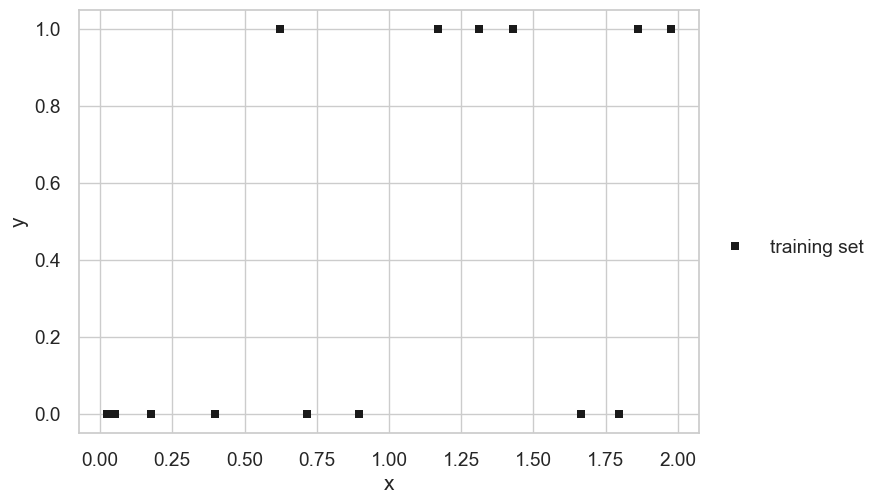

In [17]:
plt.plot(x_N, y_N, 'ks', label='training set');
plt.xlabel('x');
plt.ylabel('y');
plt.legend(bbox_to_anchor=(1.0, 0.5));

# Function for computing the log loss (aka binary cross entropy)

$$
\mathcal{L}(w, b) = \sum_{n=1}^N \text{log_loss}(y_n, \sigma(w * x_n + b) )
$$

In [18]:
def calc_loss_and_plot_probas(w=0.0, b=0.0):
    ''' Compute the log loss function at specific parameters
    
    Averages over the N training examples
    
    Args
    ----
    w : float
        Value of the weights parameters
    b : float
        Value of intercept/bias parameter
    
    Returns
    -------
    log_loss_val : float
        Value of log loss function at provided parameters
    '''
    lr = sklearn.linear_model.LogisticRegression()
    lr.fit(x_N1, y_N) # just make sure the dimensions are set up correctly
    # Deterministically set the weights and bias parameters
    lr.coef_[:] = w
    lr.intercept_[:] = b
    # Make predictions (will use the weight and bias we just set)
    yproba1_N = lr.predict_proba(x_N1)[:,1]
    
    # Compute average log loss over all N examples
    base_e_loss_val = sklearn.metrics.log_loss(y_N, yproba1_N)
    base_2_loss_val = base_e_loss_val / np.log(2.0)

    # Compute log loss at each example (useful for visualization/debugging)
    log_loss_N = [
        sklearn.metrics.log_loss([y_N[n]], [yproba1_N[n]], labels=[0,1]) / np.log(2.0)
        for n in range(N)]

    # Make plot of the probabilities
    fig, axgrid = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
    plt.plot(x_N, y_N, 'ks', label='training set');
    L = 101
    xgrid_L1 = np.linspace(-1.0, 3.0, L).reshape((L,1));
    plt.plot(xgrid_L1, lr.predict_proba(xgrid_L1)[:,1], 'b.-', label='predicted Pr(y=1|x) on dense x grid')
    plt.legend(bbox_to_anchor=(1.0, 0.5));
    
    # Create a dataframe of all x, y, proba1, and loss values
    # So that we can understand things in tabular view
    yhat_N = np.asarray(yproba1_N >= 0.5, dtype=np.int32)
    pd.set_option('display.precision', 3)
    df = pd.DataFrame(np.hstack([
            x_N,
            y_N,
            yproba1_N,
            log_loss_N,
            yhat_N,
            y_N != yhat_N,
        ]).reshape((6,N)).T,
        columns=['x', 'y', 'p(y=1|x)', 'base2_log_loss', 'yhat', 'is_error'])
    print(df)
    
    error_rate = np.mean(y_N != yhat_N)
    return base_2_loss_val, error_rate

# Part 1: A manual search for the best weight

Remember that with 1-dimensional features, your logistic regression has TWO parameters:

* weight coefficient $w$
* bias coefficient $b$

Here, we'll learn how these values impact the shape of the predicted probabilities.

### Try w = 0.0 and b = 0.0

        x    y  p(y=1|x)  base2_log_loss  yhat  is_error
0   0.025  0.0       0.5             1.0   1.0       1.0
1   0.050  0.0       0.5             1.0   1.0       1.0
2   0.175  0.0       0.5             1.0   1.0       1.0
3   0.397  0.0       0.5             1.0   1.0       1.0
4   0.622  1.0       0.5             1.0   1.0       0.0
5   0.716  0.0       0.5             1.0   1.0       1.0
6   0.898  0.0       0.5             1.0   1.0       1.0
7   1.169  1.0       0.5             1.0   1.0       0.0
8   1.311  1.0       0.5             1.0   1.0       0.0
9   1.431  1.0       0.5             1.0   1.0       0.0
10  1.663  0.0       0.5             1.0   1.0       1.0
11  1.795  0.0       0.5             1.0   1.0       1.0
12  1.863  1.0       0.5             1.0   1.0       0.0
13  1.976  1.0       0.5             1.0   1.0       0.0
average log loss on training set   = 1.000
average error rate on training set = 0.571


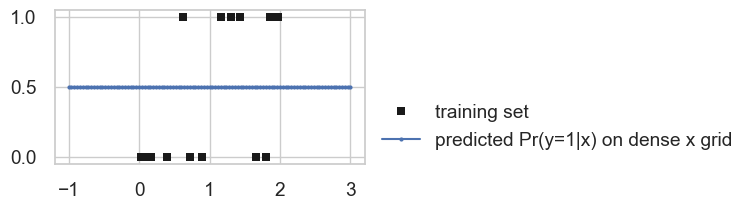

In [19]:
loss, error_rate = calc_loss_and_plot_probas(w=0.0, b=0.0)
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Try w = + 2.0 and b = 0.0

        x    y  p(y=1|x)  base2_log_loss  yhat  is_error
0   0.025  0.0     0.512           1.037   1.0       1.0
1   0.050  0.0     0.525           1.074   1.0       1.0
2   0.175  0.0     0.587           1.274   1.0       1.0
3   0.397  0.0     0.689           1.684   1.0       1.0
4   0.622  1.0     0.776           0.365   1.0       0.0
5   0.716  0.0     0.807           2.375   1.0       1.0
6   0.898  0.0     0.858           2.813   1.0       1.0
7   1.169  1.0     0.912           0.133   1.0       0.0
8   1.311  1.0     0.932           0.101   1.0       0.0
9   1.431  1.0     0.946           0.080   1.0       0.0
10  1.663  0.0     0.965           4.849   1.0       1.0
11  1.795  0.0     0.973           5.219   1.0       1.0
12  1.863  1.0     0.976           0.034   1.0       0.0
13  1.976  1.0     0.981           0.027   1.0       0.0
average log loss on training set   = 1.505
average error rate on training set = 0.571


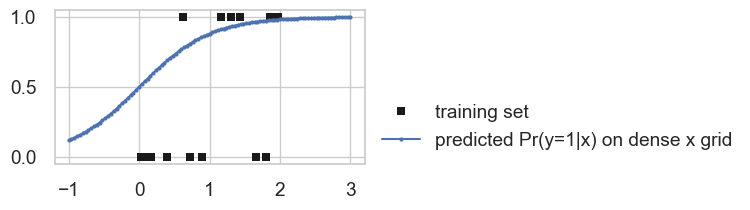

In [20]:
loss, error_rate = calc_loss_and_plot_probas(w=2.0, b=0.0)
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Try w = - 2.0 and b = 0.0

        x    y  p(y=1|x)  base2_log_loss  yhat  is_error
0   0.025  0.0     0.488           0.964   0.0       0.0
1   0.050  0.0     0.475           0.930   0.0       0.0
2   0.175  0.0     0.413           0.770   0.0       0.0
3   0.397  0.0     0.311           0.538   0.0       0.0
4   0.622  1.0     0.224           2.160   0.0       1.0
5   0.716  0.0     0.193           0.309   0.0       0.0
6   0.898  0.0     0.142           0.222   0.0       0.0
7   1.169  1.0     0.088           3.506   0.0       1.0
8   1.311  1.0     0.068           3.884   0.0       1.0
9   1.431  1.0     0.054           4.209   0.0       1.0
10  1.663  0.0     0.035           0.051   0.0       0.0
11  1.795  0.0     0.027           0.039   0.0       0.0
12  1.863  1.0     0.024           5.410   0.0       1.0
13  1.976  1.0     0.019           5.729   0.0       1.0
average log loss on training set   = 2.051
average error rate on training set = 0.429


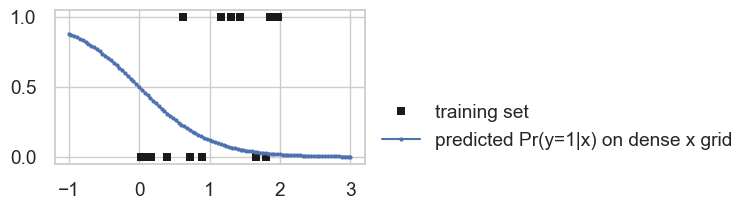

In [21]:
loss, error_rate = calc_loss_and_plot_probas(w=-2.0, b=0.0)
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Discussion 1a: Looking at examples above, do you see how the average log loss is an upper bound on the error rate? Is this a "tight" upper bound, or is there often a substantial difference? What kind of examples is the difference largest?

TODO write your answer here, then discuss with your group

### Exercise 1b: Manual training of the weight. 

For this exercise, keep $b=0.0$. 

You should manually try many possible values for $w$ (e.g. -0.2, -0.1, 0.0, 0.1, 0.2, 0.5, 1.0, 2.0, ...)

Can you find the *best possible* weight, in terms of the average log loss on the training set?

        x    y  p(y=1|x)  base2_log_loss  yhat  is_error
0   0.025  0.0     0.525       1.074e+00   1.0       1.0
1   0.050  0.0     0.550       1.151e+00   1.0       1.0
2   0.175  0.0     0.668       1.592e+00   1.0       1.0
3   0.397  0.0     0.830       2.559e+00   1.0       1.0
4   0.622  1.0     0.923       1.151e-01   1.0       0.0
5   0.716  0.0     0.946       4.212e+00   1.0       1.0
6   0.898  0.0     0.973       5.221e+00   1.0       1.0
7   1.169  1.0     0.991       1.338e-02   1.0       0.0
8   1.311  1.0     0.995       7.596e-03   1.0       0.0
9   1.431  1.0     0.997       4.705e-03   1.0       0.0
10  1.663  0.0     0.999       9.599e+00   1.0       1.0
11  1.795  0.0     0.999       1.036e+01   1.0       1.0
12  1.863  1.0     0.999       8.369e-04   1.0       0.0
13  1.976  1.0     1.000       5.326e-04   1.0       0.0
average log loss on training set   = 2.565
average error rate on training set = 0.571


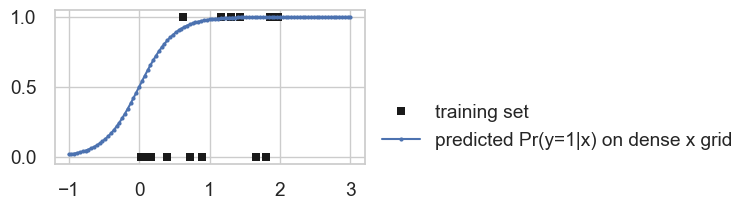

In [59]:
loss, error_rate = calc_loss_and_plot_probas(
    w=4, # TODO try different values for w here,
    b=0.0)
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

TODO write down your optimal weight here.

# Part 2: Manual training of the bias parameter

### Try w = 0.0 and b = 1.0

(Compare to w = 0.0, b = 0.0 above)

        x    y  p(y=1|x)  base2_log_loss  yhat  is_error
0   0.025  0.0     0.731           1.895   1.0       1.0
1   0.050  0.0     0.731           1.895   1.0       1.0
2   0.175  0.0     0.731           1.895   1.0       1.0
3   0.397  0.0     0.731           1.895   1.0       1.0
4   0.622  1.0     0.731           0.452   1.0       0.0
5   0.716  0.0     0.731           1.895   1.0       1.0
6   0.898  0.0     0.731           1.895   1.0       1.0
7   1.169  1.0     0.731           0.452   1.0       0.0
8   1.311  1.0     0.731           0.452   1.0       0.0
9   1.431  1.0     0.731           0.452   1.0       0.0
10  1.663  0.0     0.731           1.895   1.0       1.0
11  1.795  0.0     0.731           1.895   1.0       1.0
12  1.863  1.0     0.731           0.452   1.0       0.0
13  1.976  1.0     0.731           0.452   1.0       0.0
average log loss on training set   = 1.276
average error rate on training set = 0.571


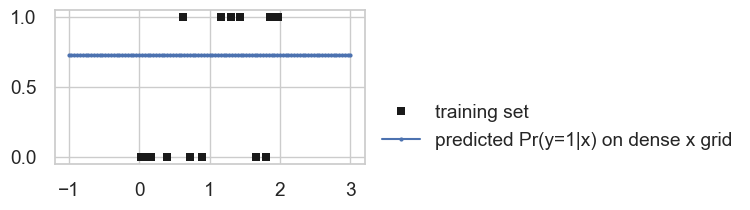

In [35]:
loss, error_rate = calc_loss_and_plot_probas(w=0.0, b=1.0)
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Try w = 2.0 and b = -1.0

(Compare to w = 2.0, b = 0.0 above)

        x    y  p(y=1|x)  base2_log_loss  yhat  is_error
0   0.025  0.0     0.279           0.472   0.0       0.0
1   0.050  0.0     0.289           0.492   0.0       0.0
2   0.175  0.0     0.343           0.606   0.0       0.0
3   0.397  0.0     0.449           0.859   0.0       0.0
4   0.622  1.0     0.561           0.835   1.0       0.0
5   0.716  0.0     0.606           1.345   1.0       1.0
6   0.898  0.0     0.689           1.686   1.0       1.0
7   1.169  1.0     0.792           0.336   1.0       0.0
8   1.311  1.0     0.835           0.260   1.0       0.0
9   1.431  1.0     0.866           0.208   1.0       0.0
10  1.663  0.0     0.911           3.490   1.0       1.0
11  1.795  0.0     0.930           3.841   1.0       1.0
12  1.863  1.0     0.939           0.092   1.0       0.0
13  1.976  1.0     0.950           0.073   1.0       0.0
average log loss on training set   = 1.042
average error rate on training set = 0.286


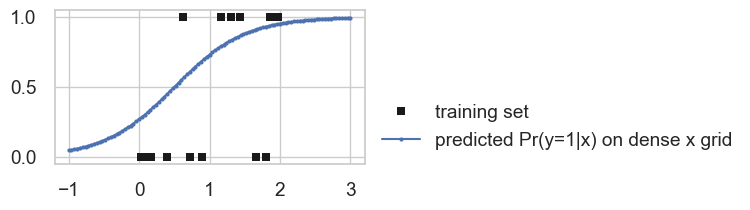

In [33]:
loss, error_rate = calc_loss_and_plot_probas(w=2.0, b=-1.0)
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Discussion 2a: What does the bias coefficient determine about the shape of the probability curve?

What can you say about how moving the bias value higher or lower impacts the resulting predictions?

### Exercise 2b: Manual training of the bias. 

For this exercise, keep your weight *fixed* to the value you found in 1b. 

You should manually try many possible values for $b$ (e.g. -0.2, -0.1, 0.0, 0.1, 0.2, 0.5, 1.0, 2.0, ...)

Can you find the *best possible* bias value, in terms of the average log loss on the training set?

        x    y  p(y=1|x)  base2_log_loss  yhat  is_error
0   0.025  0.0       0.5             1.0   1.0       1.0
1   0.050  0.0       0.5             1.0   1.0       1.0
2   0.175  0.0       0.5             1.0   1.0       1.0
3   0.397  0.0       0.5             1.0   1.0       1.0
4   0.622  1.0       0.5             1.0   1.0       0.0
5   0.716  0.0       0.5             1.0   1.0       1.0
6   0.898  0.0       0.5             1.0   1.0       1.0
7   1.169  1.0       0.5             1.0   1.0       0.0
8   1.311  1.0       0.5             1.0   1.0       0.0
9   1.431  1.0       0.5             1.0   1.0       0.0
10  1.663  0.0       0.5             1.0   1.0       1.0
11  1.795  0.0       0.5             1.0   1.0       1.0
12  1.863  1.0       0.5             1.0   1.0       0.0
13  1.976  1.0       0.5             1.0   1.0       0.0
average log loss on training set   = 1.000
average error rate on training set = 0.571


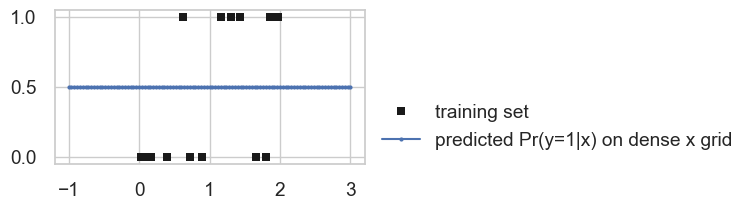

In [ ]:
loss, error_rate = calc_loss_and_plot_probas(
    w=0.0, # TODO FIX to your result from 1b
    b=0.0, # TODO try different values of b here
    )
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Exercise 2c: sklearn training of the weight and bias

Here, we'll compare your manual guess-and-check search above with the result of sklearn's built in gradient descent procedure (it uses a fancy second-order gradient descent method called L-BFGS). 

In [36]:
# Large C value means effectively no penalty on the weights
lr = sklearn.linear_model.LogisticRegression(C=1000000.0, solver='lbfgs')


**TODO** edit line below to fit model to the entire train set

In [38]:
# Call fit on whole train data
lr.fit(x_N1[3:8], y_N[3:8]) # TODO fixme

bestw = lr.coef_[0,0]
bestb = lr.intercept_[0]

In [45]:
# This block of code will pretty print the w and b values found as a result of calling 'fit'
print("Results from LogisticRegression")
print("Best w value: %.4f" % (bestw))
print("Best b value: %.4f" % (bestb))


Results from LogisticRegression
Best w value: 3.7410
Best b value: -3.3241


Visualize the best model

        x    y  p(y=1|x)  base2_log_loss  yhat  is_error
0   0.025  0.0     0.038           0.056   0.0       0.0
1   0.050  0.0     0.042           0.061   0.0       0.0
2   0.175  0.0     0.065           0.097   0.0       0.0
3   0.397  0.0     0.137           0.213   0.0       0.0
4   0.622  1.0     0.269           1.892   0.0       1.0
5   0.716  0.0     0.344           0.608   0.0       0.0
6   0.898  0.0     0.509           1.026   1.0       1.0
7   1.169  1.0     0.741           0.433   1.0       0.0
8   1.311  1.0     0.829           0.270   1.0       0.0
9   1.431  1.0     0.884           0.178   1.0       0.0
10  1.663  0.0     0.948           4.257   1.0       1.0
11  1.795  0.0     0.967           4.940   1.0       1.0
12  1.863  1.0     0.975           0.037   1.0       0.0
13  1.976  1.0     0.983           0.024   1.0       0.0
average log loss on training set   = 1.007
average error rate on training set = 0.286


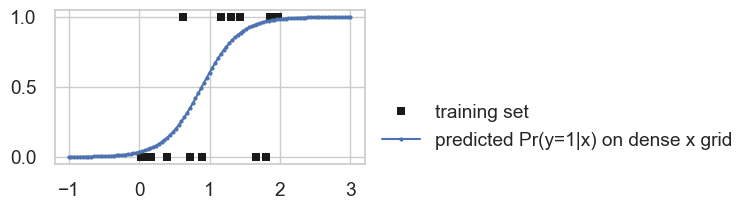

In [ ]:
loss, error_rate = calc_loss_and_plot_probas(
    w=bestw, 
    b=bestb, 
    )
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Discussion 2d: How did your guess-and-check compare?


TODO reflect with your group

# Part 3 : Manual training with F=2 features

## Setup for Parts 3

### Define simple dataset of points in 2D space

Don't worry about the details of this setup.
Just try to understand the plots below.

In [ ]:
def create_2d_dataset(N=100, noise_stddev=0.1, random_state=0):
    random_state = np.random.RandomState(int(random_state))

    mA_2 = np.asarray([1, 0])
    covA_22 = np.square(noise_stddev) * np.eye(2)
    
    mB_2 = np.asarray([1, 1])
    covB_22 = np.square(noise_stddev) * np.eye(2)

    mC_2 = np.asarray([0, 1])
    covC_22 = np.square(noise_stddev) * np.eye(2)

    # Draw data from 3 "Gaussian" blobs
    xA_N2 = random_state.multivariate_normal(mA_2, covA_22, size=N)
    xB_N2 = random_state.multivariate_normal(mB_2, covB_22, size=N)
    xC_N2 = random_state.multivariate_normal(mC_2, covC_22, size=N)

    x_N2 = np.vstack([xA_N2, xB_N2, xC_N2])
    y_N = np.hstack([np.ones(xA_N2.shape[0]), np.zeros(xB_N2.shape[0]), np.ones(xC_N2.shape[0])])
    
    return x_N2, y_N

### Create simple F=2 dataset and visualize it

Training data will be stored in these arrays:

* x_tr_N2
* y_tr_N

In [ ]:
x_tr_N2, y_tr_N = create_2d_dataset(N=40, noise_stddev=0.3)

In [ ]:
def plot_pretty_data_colored_by_labels(x_N2, y_N):
    plt.plot(x_N2[y_N==0,0], x_N2[y_N==0,1], color='r', marker='x', linestyle='', markersize=5, mew=2, label='y=0');
    plt.plot(x_N2[y_N==1,0], x_N2[y_N==1,1], color='b', marker='+', linestyle='', markersize=8, mew=2, label='y=1');

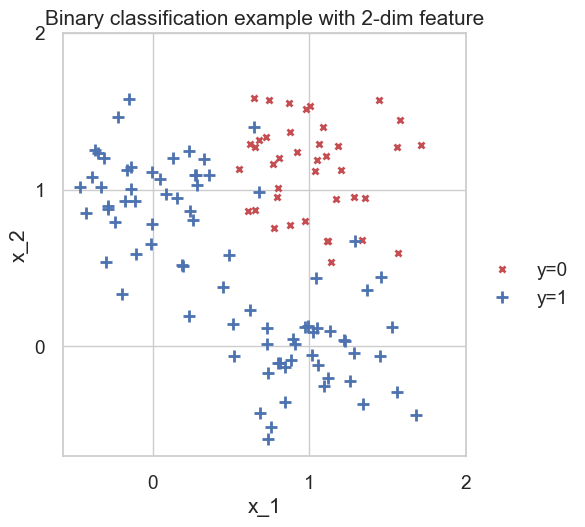

In [ ]:
plot_pretty_data_colored_by_labels(x_tr_N2, y_tr_N);
plt.legend(bbox_to_anchor=(1.0, 0.5));
plt.xlabel('x_1');
plt.ylabel('x_2');
plt.gca().set_aspect(1.0);
plt.xticks([0, 1, 2]);
plt.yticks([0, 1, 2]);
plt.title("Binary classification example with 2-dim feature");

### Define function to make pretty plots of predicted probability color fields

You don't need to understand this in detail. Just a utility function.

In [ ]:
def calc_loss_and_plot_pretty_probabilities(
        w1=0.0,
        w2=0.0,
        b=0.0,
        do_show_colorbar=True,
        x1_ticks=np.asarray([0, 2, 4]),
        x2_ticks=np.asarray([0, 2, 4]),
        c_levels=np.linspace(0, 1, 100),
        c_ticks=np.asarray([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        x1_grid=np.linspace(-1, 2.3, 100),
        x2_grid=np.linspace(-1, 2.3, 100)):
    cur_ax = plt.gca()
    G = x1_grid.size
    H = x2_grid.size
    
    # Get regular grid of G x H points, where each point is an (x1, x2) location
    x1_GH, x2_GH = np.meshgrid(x1_grid, x2_grid)
    
    # Combine the x1 and x2 values into one array
    # Flattened into M = G x H rows
    # Each row of x_M2 is a 2D vector [x_m1, x_m2]
    x_M2 = np.hstack([x1_GH.flatten()[:,np.newaxis], x2_GH.flatten()[:,np.newaxis]])
    
    # Create a convenience classifier object
    # Whose weights we'll manually fill in
    clf = sklearn.linear_model.LogisticRegression(C=10000.0)
    clf.fit(x_tr_N2[::10], y_tr_N[::10]) # just need to initialize the clf and ensure dimensionality is right
    clf.coef_[:] = np.asarray([w1, w2])
    clf.intercept_[:] = b
    
    # Predict proba for each point in the flattened grid
    yproba1_M = clf.predict_proba(x_M2)[:,1]
    
    # Reshape the M probas into the GxH 2D field
    yproba1_GH = np.reshape(yproba1_M, x1_GH.shape)
    
    cmap = plt.cm.RdYlBu
    my_contourf_h = plt.contourf(x1_GH, x2_GH, yproba1_GH, levels=c_levels, vmin=0, vmax=1.0, cmap=cmap)
    
    plt.xticks(x1_ticks, x1_ticks);
    plt.yticks(x2_ticks, x2_ticks);
    
    if do_show_colorbar:
        left, bottom, width, height = plt.gca().get_position().bounds
        cax = plt.gcf().add_axes([left+1.1*width, bottom, 0.03, height])
        plt.colorbar(my_contourf_h, orientation='vertical', cax=cax, ticks=c_ticks);
        plt.sca(cur_ax);
    plot_pretty_data_colored_by_labels(x_tr_N2, y_tr_N);
    plt.legend(bbox_to_anchor=(1.0, 0.5));
    plt.xlabel('x_1');
    plt.ylabel('x_2');
    plt.gca().set_aspect(1.0);
    plt.xticks([0, 1, 2]);
    plt.yticks([0, 1, 2]);
    plt.title("w1= % 7.3f      w2=% 7.3f      b=% 7.3f" % (w1, w2, b))
    # Compute average log loss over all N examples in training set
    base_e_loss_val = sklearn.metrics.log_loss(y_tr_N, clf.predict_proba(x_tr_N2)[:,1])
    base_2_loss_val = base_e_loss_val / np.log(2.0)
    error_rate = sklearn.metrics.zero_one_loss(y_tr_N, clf.predict_proba(x_tr_N2)[:,1] >= 0.5)
    return base_2_loss_val, error_rate

### Try w1 = 0.0, w2=2.0, b=0.0

average log loss on training set   = 1.576
average error rate on training set = 0.500


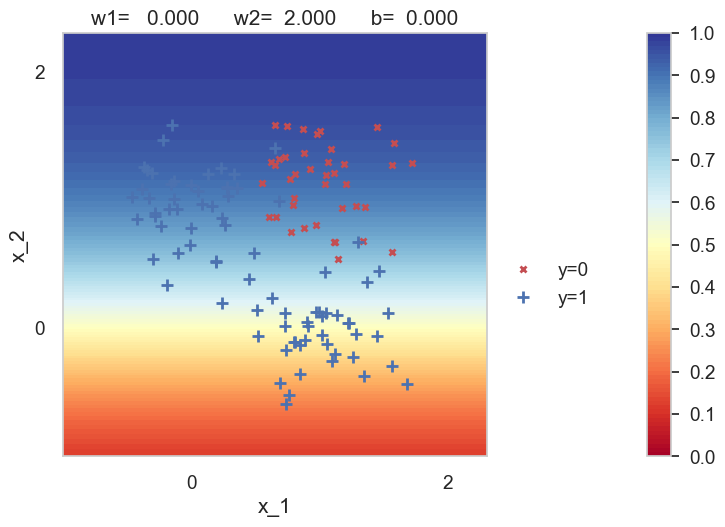

In [ ]:
loss, error_rate = calc_loss_and_plot_pretty_probabilities(
    w1=0.0,
    w2=2.0,
    b=0.0, 
    )
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Try w1 = 0.0, w2=10.0, b=0.0

average log loss on training set   = 6.110
average error rate on training set = 0.500


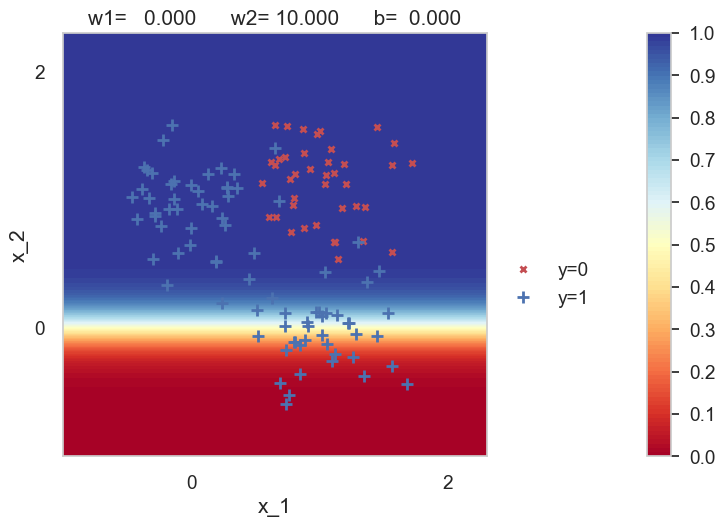

In [ ]:
loss, error_rate = calc_loss_and_plot_pretty_probabilities(
    w1=0.0,
    w2=10.0,
    b=0.0, 
    )
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Try w1 = -1.0, w2=0.0, b=2.0

average log loss on training set   = 0.850
average error rate on training set = 0.333


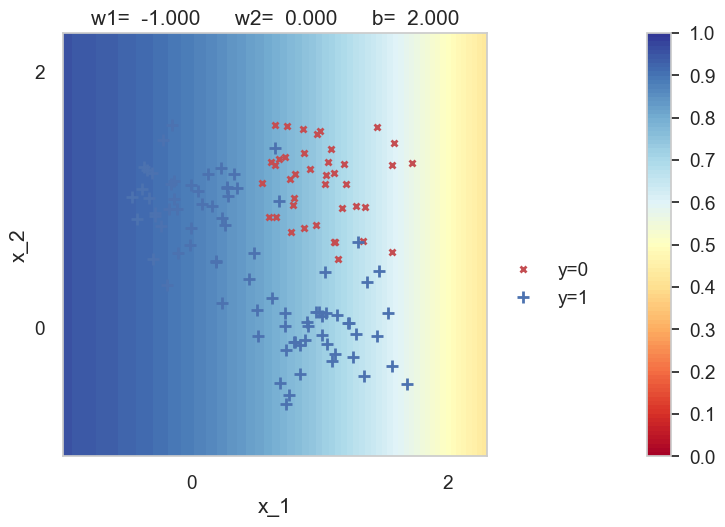

In [ ]:
loss, error_rate = calc_loss_and_plot_pretty_probabilities(
    w1=-1.0,
    w2=0.0,
    b=2.0, 
    )
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Discussion 3a: Imagine drawing a linear separator.

Imagine drawing *one line* above, so that above the line would be one label prediction and below would be another.
You want to draw this line to minimize error rate on the training set above.

What line would you draw? Describe it graphically (e.g. at value $x_1 = ?$, the line would hit $x_2 = ?$)


In [ ]:
# TODO provide a description of line and discuss with your group 

### Discussion 3b: Imagine your predicted probabilities

Given your line above, how do you imagine the probabilities changing as you move *perpendicularly* from that line?

Do you want the probabilities to saturate rapidly (e.g. so they become solid blue (y=1) or solid red (y=0) very close to the line)?

Or do you want the probabilities to change gradually (e.g. so most of the picture would not be solid blue or solid red)?

In [ ]:
# TODO provide description and discuss with your group

### Exercise 3b: Manually finding parameters for this toy dataset via guess-and-check

Can you manually search for w1, w2, and b values that give lowest loss on the training set?

Just keep guessing values for each parameter until you find a good solution

**Hint**: you should be able to get error rate less than 0.15

average log loss on training set   = 0.850
average error rate on training set = 0.333


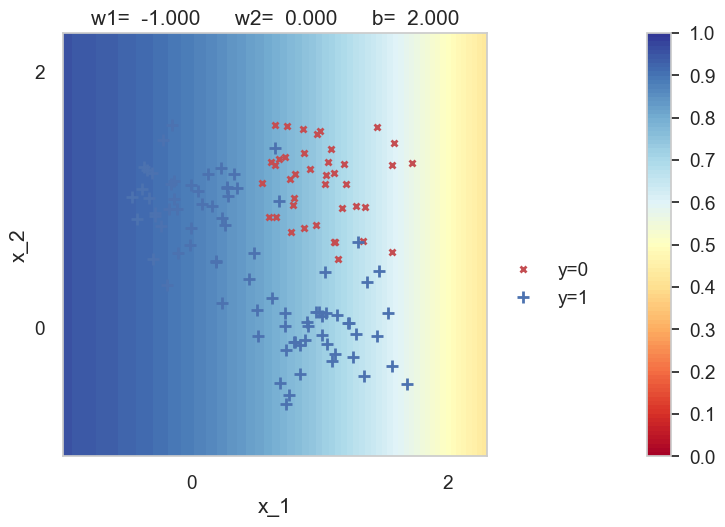

In [ ]:
loss, error_rate = calc_loss_and_plot_pretty_probabilities(
    w1=-1.0, # TODO edit this value!
    w2=0.0,  # TODO also edit this value
    b=2.0,   # TODO also edit this value
    )
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Exercise 3c: Compare to optimal weights from sklearn

Using sklearn, we now want to fit a logistic regression model to the training set.

This will minimize the average log loss via gradient descent.

In [ ]:
lr = sklearn.linear_model.LogisticRegression(C=1000000., solver='lbfgs')

In [ ]:
lr.fit(x_tr_N2, y_tr_N)

LogisticRegression(C=1000000.0)

In [ ]:
# This block of code will pretty print the w and b values found as a result of calling 'fit'
print("Results from LogisticRegression")

print("Best w1 value: %.4f" % (lr.coef_[0,0]))
print("Best w2 value: %.4f" % (lr.coef_[0,1]))
print("Best b value: %.4f" % (lr.intercept_[0]))


Results from LogisticRegression
Best w1 value: -6.8321
Best w2 value: -7.7333
Best b value: 12.1719


Now plug the estimated weights and bias in

average log loss on training set   = 0.244
average error rate on training set = 0.075


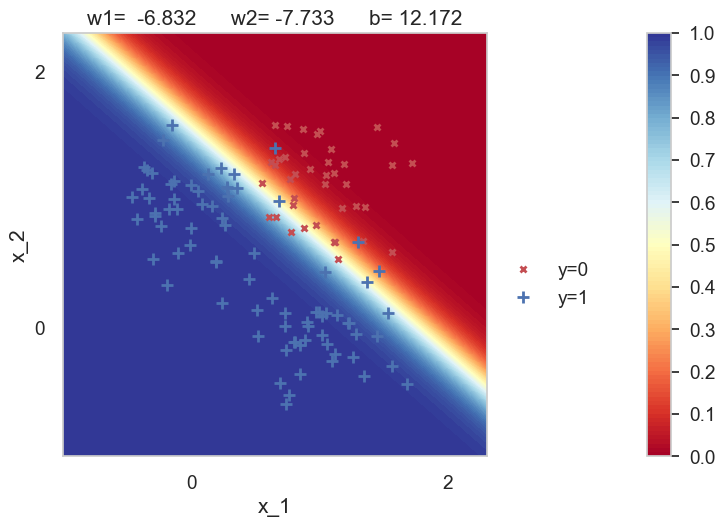

In [ ]:
loss, error_rate = calc_loss_and_plot_pretty_probabilities(
    w1=lr.coef_[0,0],
    w2=lr.coef_[0,1],
    b=lr.intercept_[0],
    )
print("average log loss on training set   = %.3f" % loss)
print("average error rate on training set = %.3f" % error_rate)

### Discussion 3c: How did your guess-and-check compare?


TODO reflect with your group